<a href="https://colab.research.google.com/github/plaban1981/Pytorch_lightning/blob/main/Kitchenware_Multiclass_Classification_pytorch_lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

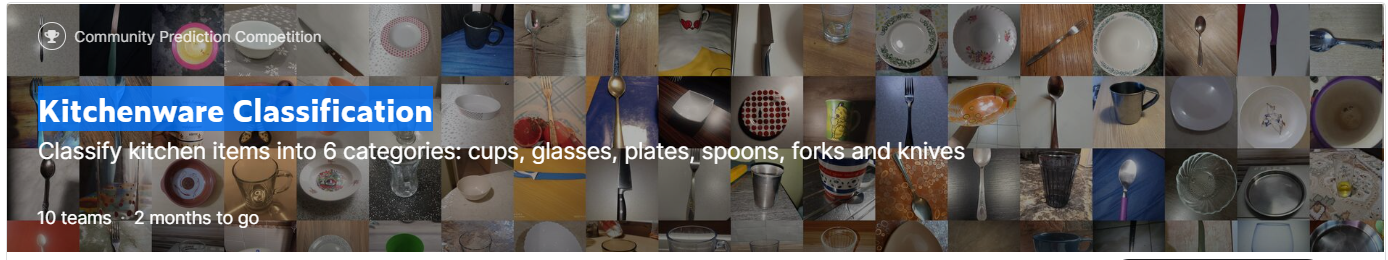

In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 24.8 MB/s 
     |████████████████████████████████| 512 kB 77.3 MB/s 
     |████████████████████████████████| 125 kB 73.5 MB/s 
     |████████████████████████████████| 87 kB 8.5 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=0530688315d0b4216f0edb1325e7dc18239ae38e9e5c9096b8b8bdde4a6ef470
  Stored in directory: /root/.cache/pip/wheels/1f/10/06/2a990ee4d73a8479fe2922445e8a876d38cfbfed052284c6a1
Successfully built fire


## Install required libraries

In [4]:
#refer to book for correct version of package and import here
import os
import shutil
import opendatasets as od
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchmetrics.functional import accuracy
import pytorch_lightning as pl

In [5]:
print("pandas version:",pd.__version__)
print("numpy version:",np.__version__)
#print("seaborn version:",sns.__version__)
print("torch version:",torch.__version__)
print("pytorch ligthening version:",pl.__version__)

pandas version: 1.3.5
numpy version: 1.21.6
torch version: 1.12.1+cu113
pytorch ligthening version: 1.8.3.post1


## Download data from Kaggle

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Import Data

In [7]:
import pandas as pd
train = pd.read_csv("/content/drive/MyDrive/Kitchen_Classification/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Kitchen_Classification/test.csv")

In [8]:
train.head()

,Id,label
0,2441,glass
1,0,cup
2,2442,glass
3,6535,spoon
4,4814,plate


In [9]:
test.head()

,Id
0,6534
1,3504
2,1649
3,4815
4,1651


In [10]:
train['image'] = train['Id'].map(lambda x: f'{x:0>4}.jpg')
test['image'] = test['Id'].map(lambda x: f'{x:0>4}.jpg')

In [11]:
train.head()

,Id,label,image
0,2441,glass,2441.jpg
1,0,cup,0000.jpg
2,2442,glass,2442.jpg
3,6535,spoon,6535.jpg
4,4814,plate,4814.jpg


In [12]:
test.head()

,Id,image
0,6534,6534.jpg
1,3504,3504.jpg
2,1649,1649.jpg
3,4815,4815.jpg
4,1651,1651.jpg


## Make directory train and test to copy images to these folders.

In [ ]:
!mkdir /content/drive/MyDrive/Kitchen_Classification/train

In [ ]:
!mkdir /content/drive/MyDrive/Kitchen_Classification/test

In [ ]:
train_image_list = train['image'].values.tolist()
test_image_list = test['image'].values.tolist()

In [ ]:
import shutil
import os
train_src = "/content/drive/MyDrive/Kitchen_Classification/images"
train_dest = "/content/drive/MyDrive/Kitchen_Classification/train"
for image in train_image_list:
  src = os.path.join(train_src,image)
  shutil.copy(src,train_dest)



In [ ]:
import shutil
import os
from tqdm import tqdm
train_src = "/content/drive/MyDrive/Kitchen_Classification/images"
test_dest = "/content/drive/MyDrive/Kitchen_Classification/test"
for image in tqdm(test_image_list):
  src = os.path.join(train_src,image)
  shutil.copy(src,test_dest)

100%|██████████| 2362/2362 [15:29<00:00,  2.54it/s]


In [13]:
print('No. of images in training dataset: ', len(os.listdir("/content/drive/MyDrive/Kitchen_Classification/train")))
print('No. of images in testing dataset: ', len(os.listdir("/content/drive/MyDrive/Kitchen_Classification/test")))

No. of images in training dataset:  5559
No. of images in testing dataset:  2362


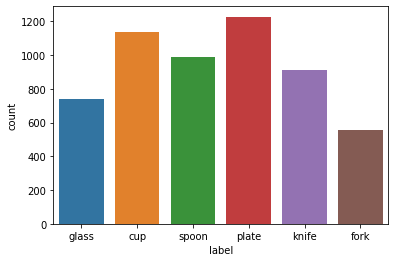

In [14]:
import seaborn as sns
sns.countplot(x='label',data=train)

* the dataset in not highly imbalanced

In [14]:
train_imgs_orig = os.listdir("/content/drive/MyDrive/Kitchen_Classification/train")

In [15]:
train_imgs_orig[0]

'6230.jpg'

In [16]:
train.loc[train['image'] == train_imgs_orig[0], 'label'].values[0]

'plate'

In [32]:
train['label'].nunique()

6

In [52]:
train['label'].unique()

array(['glass', 'cup', 'spoon', 'plate', 'knife', 'fork'], dtype=object)

## Visualize Training Data

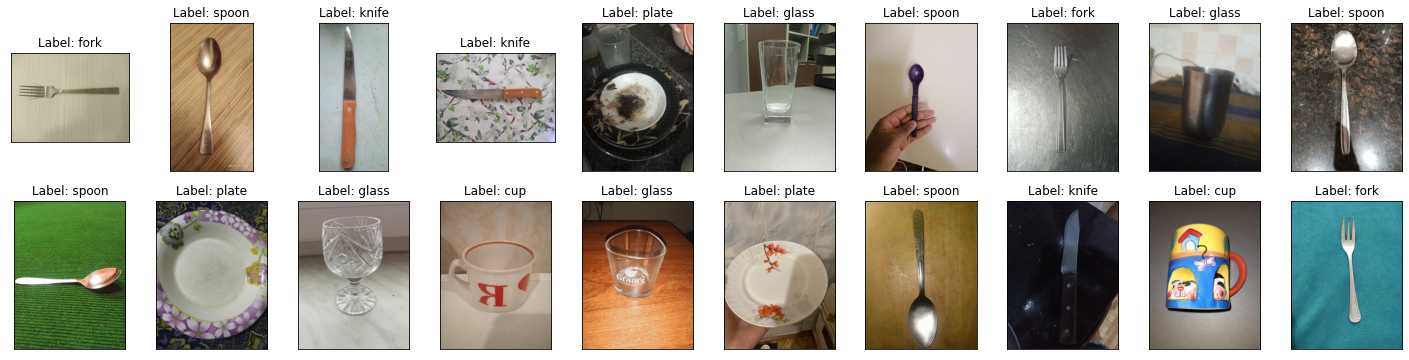

In [17]:
fig = plt.figure(figsize=(25, 6))
for idx, img in enumerate(np.random.choice(train_imgs_orig, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("/content/drive/MyDrive/Kitchen_Classification/train/" + img)
    plt.imshow(im)
    lab = train.loc[train['image'] == img, 'label'].values[0]
    ax.set_title(f'Label: {lab}')

In [53]:
label_map = {'glass':2, 'cup' :0, 'spoon':5, 'plate':4, 'knife':3, 'fork':1}

In [54]:
train['label_map'] = train['label'].map(label_map)
train.head()

,Id,label,image,label_map
0,2441,glass,2441.jpg,2
1,0,cup,0000.jpg,0
2,2442,glass,2442.jpg,2
3,6535,spoon,6535.jpg,5
4,4814,plate,4814.jpg,4


## Data Augmentation

In [18]:
data_T_train = T.Compose([
    T.CenterCrop(32),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    ])
data_T_test = T.Compose([
    T.CenterCrop(32),
    T.ToTensor(),
    ])

In [55]:
# dictionary with labels and ids of train data
img_label_dict = {k:v for k, v in zip(train['image'], train['label_map'])}

In [56]:
img_label_dict

{'2441.jpg': 2,
 '0000.jpg': 0,
 '2442.jpg': 2,
 '6535.jpg': 5,
 '4814.jpg': 4,
 '0001.jpg': 0,
 '3505.jpg': 3,
 '1650.jpg': 1,
 '0002.jpg': 0,
 '3506.jpg': 3,
 '0003.jpg': 0,
 '0004.jpg': 0,
 '0005.jpg': 0,
 '3507.jpg': 3,
 '1653.jpg': 1,
 '0006.jpg': 0,
 '4816.jpg': 4,
 '4817.jpg': 4,
 '0008.jpg': 0,
 '6537.jpg': 5,
 '0009.jpg': 0,
 '6538.jpg': 5,
 '3509.jpg': 3,
 '6539.jpg': 5,
 '6540.jpg': 5,
 '0010.jpg': 0,
 '6541.jpg': 5,
 '3510.jpg': 3,
 '4819.jpg': 4,
 '4820.jpg': 4,
 '3512.jpg': 3,
 '0011.jpg': 0,
 '2444.jpg': 2,
 '0012.jpg': 0,
 '6542.jpg': 5,
 '3513.jpg': 3,
 '4822.jpg': 4,
 '4823.jpg': 4,
 '2445.jpg': 2,
 '4824.jpg': 4,
 '4825.jpg': 4,
 '3514.jpg': 3,
 '1655.jpg': 1,
 '0013.jpg': 0,
 '4827.jpg': 4,
 '3516.jpg': 3,
 '3517.jpg': 3,
 '3518.jpg': 3,
 '4828.jpg': 4,
 '0016.jpg': 0,
 '6546.jpg': 5,
 '3519.jpg': 3,
 '4830.jpg': 4,
 '1657.jpg': 1,
 '3520.jpg': 3,
 '0019.jpg': 0,
 '2447.jpg': 2,
 '2448.jpg': 2,
 '6547.jpg': 5,
 '6548.jpg': 5,
 '2449.jpg': 2,
 '4831.jpg': 4,
 '4832.j

In [57]:
class LoadKitchenDataset(Dataset):
    def __init__(self, data_folder, 
                 transform = T.Compose([T.CenterCrop(32),T.ToTensor()]), dict_labels={}):
        self.data_folder = data_folder
        self.list_image_files = [s for s in os.listdir(data_folder)]
        self.transform = transform
        self.dict_labels = dict_labels
        self.labels = [dict_labels[i] for i in self.list_image_files]

    def __len__(self):
        return len(self.list_image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_folder, self.list_image_files[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        #img_name_short = self.list_image_files[idx].split('.')[0]
        img_name_short = self.list_image_files[idx]
        label = self.dict_labels[img_name_short]
        return image, label

In [58]:
class LoadKitchenDatasettest(Dataset):
    def __init__(self, data_folder, 
                 transform = T.Compose([T.CenterCrop(32),T.ToTensor()]), dict_labels={}):
        self.data_folder = data_folder
        self.list_image_files = [s for s in os.listdir(data_folder)]
        self.transform = transform
        
    def __len__(self):
        return len(self.list_image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_folder, self.list_image_files[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        #img_name_short = self.list_image_files[idx].split('.')[0]
        img_name_short = self.list_image_files[idx]
        return image

In [59]:
%%time
# Load train data 
train_set = LoadKitchenDataset(data_folder='/content/drive/MyDrive/Kitchen_Classification/train/', 
                        # datatype='train', 
                        transform=data_T_train, dict_labels=img_label_dict)

CPU times: user 2.95 ms, sys: 1.96 ms, total: 4.91 ms
Wall time: 70.7 ms


In [24]:
train.shape

(5559, 3)

## Test and Validation Split

In [60]:
%%time
train_set, val_set = torch.utils.data.random_split(train_set , [4448, 1111])

CPU times: user 1.16 ms, sys: 9 µs, total: 1.17 ms
Wall time: 906 µs


In [61]:
%%time
test_set = LoadKitchenDatasettest(data_folder='/content/drive/MyDrive/Kitchen_Classification/test/')

CPU times: user 3.53 ms, sys: 929 µs, total: 4.46 ms
Wall time: 29 ms


## Dataloaders

In [62]:
batch_size = 8

train_dataloader = DataLoader(train_set, batch_size, num_workers=0, pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size, num_workers=0, pin_memory=True)

In [63]:
test_dataloader = DataLoader(test_set, 1, num_workers=0, pin_memory=True)

In [64]:
class CNNImageClassifier(pl.LightningModule):

    def __init__(self, learning_rate = 0.001):
        super().__init__()

        self.learning_rate = learning_rate

        self.conv_layer1 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv_layer2 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.fully_connected_1 =nn.Linear(in_features=16 * 16 * 6,out_features=1000)
        self.fully_connected_2 =nn.Linear(in_features=1000,out_features=500)
        self.fully_connected_3 =nn.Linear(in_features=500,out_features=250)
        self.fully_connected_4 =nn.Linear(in_features=250,out_features=120)
        self.fully_connected_5 =nn.Linear(in_features=120,out_features=60)
        self.fully_connected_6 =nn.Linear(in_features=60,out_features=6)
        self.loss = nn.CrossEntropyLoss()
        self.save_hyperparameters()

    def forward(self, input):
        output=self.conv_layer1(input)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv_layer2(output)
        output=self.relu2(output)
        output=output.view(-1, 6*16*16)
        output = self.fully_connected_1(output)
        output = self.fully_connected_2(output)
        output = self.fully_connected_3(output)
        output = self.fully_connected_4(output)
        output = self.fully_connected_5(output)
        output = self.fully_connected_6(output)
        return output

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs) 
        train_accuracy = accuracy(outputs, targets, task='multiclass', num_classes=6)
        loss = self.loss(outputs, targets)
        self.log('train_accuracy', train_accuracy, prog_bar=True)
        self.log('train_loss', loss)
        return {"loss":loss, "train_accuracy":train_accuracy}

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        test_accuracy = accuracy(outputs, targets, task='multiclass', num_classes=6)
        loss = self.loss(outputs, targets)
        self.log('test_accuracy', test_accuracy)
        return {"test_loss":loss, "test_accuracy":test_accuracy}

    def configure_optimizers(self):
        params = self.parameters()
        optimizer = optim.Adam(params=params, lr = self.learning_rate)
        return optimizer

    # Calculate accuracy for each batch at a time
    def binary_accuracy(self, outputs, targets):
        _, outputs = torch.max(outputs,1)
        correct_results_sum = (outputs == targets).sum().float()
        acc = correct_results_sum/targets.shape[0]
        return acc

    def predict_step(self, batch, batch_idx ):
        return self(batch)

In [66]:
!mkdir /content/cnn

In [68]:
ckpt_dir = "/content/cnn"
ckpt_callback = pl.callbacks.ModelCheckpoint(every_n_epochs=10)
from pytorch_lightning.callbacks import EarlyStopping
early_stopping = EarlyStopping('val_loss')
model = CNNImageClassifier()
trainer = pl.Trainer(default_root_dir=ckpt_dir,
                     accelerator='gpu', 
                     devices=1 if torch.cuda.is_available() else None, 
                     auto_lr_find = True,
                    #  progress_bar_refresh_rate=30,
                        callbacks=[ckpt_callback],
                        log_every_n_steps=1,
                        max_epochs=50)
trainer.fit(model, train_dataloaders=train_dataloader,val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type             | Params
--------------------------------------------------------
0  | conv_layer1       | Conv2d           | 84    
1  | relu1             | ReLU             | 0     
2  | pool              | MaxPool2d        | 0     
3  | conv_layer2       | Conv2d           | 168   
4  | relu2             | ReLU             | 0     
5  | fully_connected_1 | Linear           | 1.5 M 
6  | fully_connected_2 | Linear           | 500 K 
7  | fully_connected_3 | Linear           | 125 K 
8  | fully_connected_4 | Line

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


## Evaluate the Model

In [69]:
model.eval()
preds = []
for batch_i, (data, target) in enumerate(val_dataloader):
    data, target = data.cuda(), target.cuda()
    output = model.cuda()(data)

    pr = output.detach().cpu().numpy()
    for i in pr:
        preds.append(i)

In [70]:
len(preds)

1111

In [71]:
len(train_set.dataset.labels)

5559

In [72]:
len(val_set.dataset.labels)

5559

In [73]:
predictions  = [np.argmax(item) for item in preds]

In [74]:
len(predictions)

1111

In [75]:
val_preds = pd.DataFrame({'imgs': val_set.dataset.list_image_files[-1111:], 'labels':val_set.dataset.labels[-1111:],  'preds': predictions})

In [76]:
val_preds

,imgs,labels,preds
0,2630.jpg,2,4
1,6810.jpg,5,4
2,1787.jpg,1,0
3,2631.jpg,2,0
4,5115.jpg,4,0
...,...,...,...
1106,6676.jpg,5,4
1107,6677.jpg,5,0
1108,3635.jpg,3,0
1109,3636.jpg,3,5


In [79]:
label_map

{'glass': 2, 'cup': 0, 'spoon': 5, 'plate': 4, 'knife': 3, 'fork': 1}

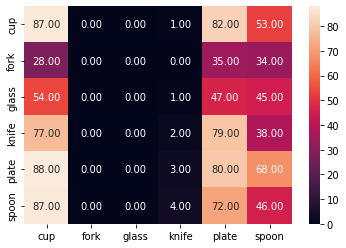

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(val_preds['labels'],val_preds['preds'])
sns.heatmap(cm,annot=True,fmt=".2f",xticklabels=['cup','fork','glass','knife','plate','spoon'],yticklabels=['cup','fork','glass','knife','plate','spoon'])

In [82]:
from sklearn.metrics import accuracy_score
print(f"Accuracy Score : {accuracy_score(val_preds['labels'],val_preds['preds'])}")

Accuracy Score : 0.1935193519351935


## Make Inference on test data

In [83]:
final_inference = trainer.predict(model, test_dataloader) 

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 556it [00:00, ?it/s]

In [84]:
inference = [ item.detach().cpu().numpy() for item in final_inference]

In [85]:
predicted_label = [np.argmax(item) for item in inference]

In [86]:
test_image = os.listdir("/content/drive/MyDrive/Kitchen_Classification/test")

In [87]:
sub = pd.DataFrame({'image':test_image,'label':predicted_label})

In [88]:
sub

,image,label
0,5805.jpg,4
1,3049.jpg,4
2,2085.jpg,5
3,5808.jpg,4
4,5809.jpg,4
...,...,...
2357,2604.jpg,0
2358,2605.jpg,4
2359,6772.jpg,5
2360,0250.jpg,4
